# Dataset: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant


# Attribute Information:

## Features consist of hourly average ambient variables 
### - Temperature (T) in the range 1.81°C and 37.11°C,
### - Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
### - Relative Humidity (RH) in the range 25.56% to 100.16%
### - Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg
### - Net hourly electrical energy output (EP) 420.26-495.76 MW
### The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.
















In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib notebook
import sys
sys.path.append('./python')
from generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
import base64
from sklearn.metrics import mean_squared_error
from collections import Counter
from IPython.core.display import display, HTML
import time

In [3]:
df = pd.read_excel("Folds5x2_pp.xlsx")

In [4]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [5]:
x_data= df.drop('PE', axis=1).copy()

In [6]:
x_data.head()

,AT,V,AP,RH
0,14.96,41.76,1024.07,73.17
1,25.18,62.96,1020.04,59.08
2,5.11,39.40,1012.16,92.14
3,20.86,57.32,1010.24,76.64
4,10.82,37.50,1009.23,96.62


In [7]:
target = df['PE'].copy()

# Check data using: «facets: https://github.com/PAIR-code/facets»

In [8]:
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(x_data,target,test_size=0.3)

In [9]:
gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': X_train_temp},
                                  {'name': 'test', 'table': X_test_temp}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

In [35]:
HTML_TEMPLATE = """<link rel="import"
            href="https://raw.githubusercontent.com/PAIR-code/facets/master/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

In [11]:
df.corr()

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


In [12]:
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


# Notes:
### There arent any missing data.
### Linear relationship:
### ΑΤ: -0.948128 negative linear relationship with the target column, also  V: -0.869780
### ΑP: 0.518429 positive linear relationship with the target column, also RH: 0.389794

## Split 70/30

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x_data,target,test_size=0.3)

## Data nomalization using StandarScaler()

In [14]:
scaler = StandardScaler()

In [15]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [16]:
X_train = pd.DataFrame(scaler.transform(X_train),
                              columns=X_train.columns,
                              index=X_train.index)

In [17]:
X_test = pd.DataFrame(scaler.transform(X_test),
                             columns=X_test.columns,
                             index=X_test.index)

In [18]:
X_train.head()

,AT,V,AP,RH
5400,-0.163310,-0.087487,0.003546,0.668240
8509,1.095606,1.056987,-0.982498,-0.967235
9016,-0.300353,-0.570324,0.011988,1.697295
6191,0.910195,0.441035,-0.008273,0.010884
4892,0.555495,1.016029,-1.016267,1.151448


In [19]:
X_test.head()

,AT,V,AP,RH
4661,0.789275,1.579995,0.378377,0.514742
5908,-0.082696,-0.507311,-1.205371,0.147173
9146,0.912882,1.226335,-1.786191,0.690955
249,-1.701686,-1.432814,1.440401,0.746021
4080,-1.798423,-1.020867,-1.825025,1.055082


## Create 'Feature Columns'

In [20]:
at = tf.feature_column.numeric_column('AT')
v = tf.feature_column.numeric_column('V')
ap = tf.feature_column.numeric_column('AP')
rh = tf.feature_column.numeric_column('RH')

In [21]:
feat_cols = [at,v,ap,rh]

In [22]:
feat_cols

[_NumericColumn(key='AT', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='V', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='AP', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='RH', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [23]:
batch_size = 32
learning_rate = 0.001
epochs_num = 10

## Define the 'Input Training Function'

In [24]:
train_func = tf.estimator.inputs.pandas_input_fn(x=X_train, y=y_train,
                                                batch_size=batch_size,num_epochs=epochs_num,
                                                shuffle=True)

## Define the 'Prediction Function'

In [25]:
predict_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test,
                                                        batch_size=batch_size,
                                                        num_epochs=1,
                                                        shuffle=False)

## Define the 'Estimator Model'

In [26]:
model = tf.estimator.LinearRegressor(feature_columns=feat_cols,
                                     model_dir='model/estimator_'f'{int(time.time())}',
                                     optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model/estimator_1549035078', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001717C1F9908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Train

In [27]:
model.train(input_fn=train_func,steps=500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into model/estimator_1549035078\model.ckpt.
INFO:tensorflow:loss = 6571105.5, step = 1
INFO:tensorflow:global_step/sec: 579.583
INFO:tensorflow:loss = 853.2485, step = 101 (0.178 sec)
INFO:tensorflow:global_step/sec: 721.349
INFO:tensorflow:loss = 1179.4269, step = 201 (0.136 sec)
INFO:tensorflow:global_step/sec: 721.807
INFO:tensorflow:loss = 530.02014, step = 301 (0.138 sec)
INFO:tensorflow:global_step/sec: 737.258
INFO:tensorflow:loss = 562.1834, step = 401 (0.137 sec)
INFO:tensorflow:Saving checkpoints for 500 into model/estimator_1549035078\model.ckpt.
INFO:tensorflow:Loss for final step: 484.532.


## Predictions

In [28]:
pred_gen = model.predict(predict_input_func)

In [29]:
predictions = list(pred_gen)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/estimator_1549035078\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [30]:
predictions

[{'predictions': array([436.96036], dtype=float32)},
 {'predictions': array([456.68124], dtype=float32)},
 {'predictions': array([435.05585], dtype=float32)},
 {'predictions': array([483.0683], dtype=float32)},
 {'predictions': array([481.08517], dtype=float32)},
 {'predictions': array([436.00824], dtype=float32)},
 {'predictions': array([462.56784], dtype=float32)},
 {'predictions': array([427.82587], dtype=float32)},
 {'predictions': array([429.13223], dtype=float32)},
 {'predictions': array([450.43292], dtype=float32)},
 {'predictions': array([435.04648], dtype=float32)},
 {'predictions': array([439.99136], dtype=float32)},
 {'predictions': array([475.1091], dtype=float32)},
 {'predictions': array([473.7741], dtype=float32)},
 {'predictions': array([470.41403], dtype=float32)},
 {'predictions': array([435.3899], dtype=float32)},
 {'predictions': array([466.25296], dtype=float32)},
 {'predictions': array([455.5597], dtype=float32)},
 {'predictions': array([439.65237], dtype=float32)}

In [31]:
y_test.head(19)

4661    435.12
5908    454.35
9146    428.60
249     486.37
4080    485.08
6545    430.89
9045    462.12
5663    426.07
8165    430.11
5455    447.64
2393    431.93
7760    446.50
4579    471.56
7441    469.12
6517    474.79
7435    440.93
7359    465.00
156     455.86
4324    434.57
Name: PE, dtype: float64

In [32]:
final_preds = []
for pred in predictions:
    final_preds.append(pred['predictions'])

## Error

In [33]:
mean_squared_error(y_test,final_preds)**0.5

4.503233821436102

## Visualize the linear model

<IPython.core.display.Javascript object>


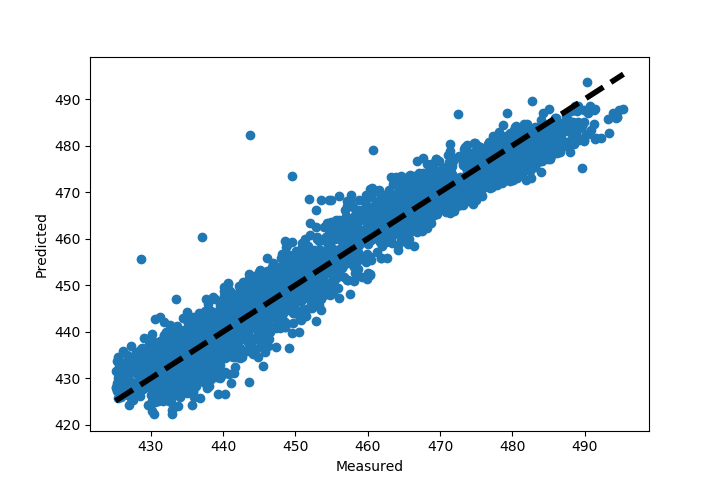

In [34]:
fig, ax = plt.subplots()
ax.scatter(y_test, final_preds)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
# https://scikit-learn.org/0.18/auto_examples/plot_cv_predict.html